In [1]:
import sys
sys.path.append('../')
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import matplotlib.pyplot as plt
plt.rc('text',usetex=True)
plt.rc('font',family='serif')

from pylab import *
import pickle
from math import log
from torch.nn import parameter

from source.common import *
from source.Calibration import CalibrationProblem
from source.DataGenerator import OnePointSpectraDataGenerator

In [2]:
####################################
### Configuration
####################################

config = {
    'type_EddyLifetime' :   'tauNet',  ### 'const', TwoThird', 'Mann', 'tauNet'
    'type_PowerSpectra' :   'RDT', ### 'RDT', 'zetaNet', 'C3Net', 'Corrector'
    'nlayers'           :   2,
    'hidden_layer_size' :   10,
    # 'nModes'            :   5, ### number of modes in the rational function in tauNet ### deprecated
    'learn_nu'          :   False, ### NOTE: Experiment 1: False, Experiment 2: True
    'plt_tau'           :   True,
    'tol'               :   1.e-3, ### not important
    'lr'                :   1,     ### learning rate
    'penalty'           :   1.e-1,
    'regularization'    :   1.e-1,
    'nepochs'           :   200,
    'curves'            :   [0,1,2,3],
    'data_type'         :   'Kaimal', ### 'Kaimal', 'SimiuScanlan', 'SimiuYeo', 'iso'
    'Uref'              :   10, # m/s
    'zref'              :   90, #m
    'domain'            :   np.logspace(-3, 0, 20), ### NOTE: Experiment 1: np.logspace(-1, 2, 20), Experiment 2: np.logspace(-2, 2, 40)
    'noisy_data'        :   0*3.e-1, ### level of the data noise  ### NOTE: Experiment 1: zero, Experiment 2: non-zero
    'output_folder'     :   '/Users/gdeskos/work_in_progress/WindGenerator/data/'
}
pb = CalibrationProblem(**config)

In [3]:
####################################
### Initialize Parameters
####################################

#Calculating turbulence parameters according to IEC standards
# we assume a hub height z=150m corresponding to the IEA 15MW wind turbine hub height
zref=config['zref']; # Hub height in meters
Uref=config['Uref']; # Average Hub height velocity in m/s
Iref = 0.14
sigma1=Iref*(0.75*Uref+5.6)
Lambda1=42; # Longitudinal turbulence scale parameter at hub height


#Mann model parameters
#Gamma = 3.9
#sigma = 0.55*sigma1
#L=0.8*Lambda1;


z0=0.1
ustar=0.41*Uref/log(zref/z0)

L     = 0.59*zref
Gamma = 3.9
sigma = 6.4/zref**(2./3.)

print(L,Gamma,sigma)

sigma = sigma * L**(5./3.)

parameters = pb.parameters
parameters[:3] = [log(L), log(Gamma), log(sigma)] #All of these parameters are positive 
#so we can train the NN for the log of these parameters. 
pb.parameters = parameters[:len(pb.parameters)]

k1_data_pts = config['domain'] #np.logspace(-1, 2, 20)
DataPoints  = [ (k1, 1) for k1 in k1_data_pts ]
Data = OnePointSpectraDataGenerator(DataPoints=DataPoints, **config).Data

### Data perturbation
data_noise_magnitude = config['noisy_data']
if data_noise_magnitude:
    Data[1][:] *= np.exp(np.random.normal(loc=0, scale=data_noise_magnitude, size=Data[1].shape))

DataValues = Data[1]

53.099999999999994 3.9 0.31867767086628734


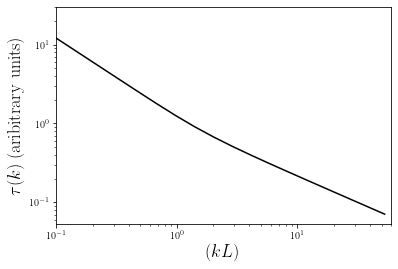

In [6]:
IECtau=MannEddyLifetime(k1_data_pts*L)
plt.figure(1)
plt.loglog(k1_data_pts*L,IECtau,'k')
plt.xlim(0.1,60)
plt.ylabel(r'$\tau(k)$ (aribitrary units)',fontsize=18)
plt.xlabel(r'$(kL)$',fontsize=18)
plt.savefig('tau.png')

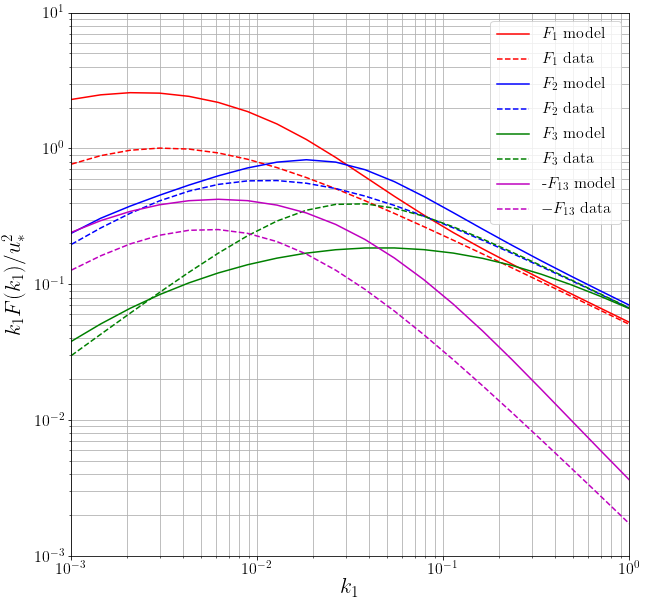

In [9]:
####################################
### Just plot
####################################

kF = pb.eval(k1_data_pts)
plt.figure(1,figsize=(10,10))
clr=['red','blue','green']
for i in range(3):
    plt.plot(k1_data_pts, kF[i], '-', color=clr[i], label=r'$F_{0:d}$ model'.format(i+1))
    plt.plot(k1_data_pts, DataValues[:,i,i], '--',color=clr[i],label=r'$F_{0:d}$ data'.format(i+1) )#, label=r'$F_{0:d}$ data'.format(i+1))
plt.plot(k1_data_pts, -kF[3], '-m', label=r'-$F_{13}$ model')
plt.plot(k1_data_pts, -DataValues[:,0,2], '--m', label=r'$-F_{13}$ data')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k_1$',fontsize=22)
plt.xlim(0.001,1)
plt.ylim(0.001,10)


plt.ylabel(r'$k_1 F(k_1)/u_\ast^2$',fontsize=22)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(which='both')
plt.savefig(config['output_folder']+'initial_Kaimal_guess.pdf',dpi=100)


Callibrating MannNet...
Initial loss:  0.29866342016038433

-> Epoch 0

pen =  0.00013121603745382343
reg =  0.004838491310666463
loss  =  0.3036331275085046
pen =  4.549093228350322e-05
reg =  0.004832914355573758
loss  =  0.29046367536260664
pen =  8.158334251642287e-05
reg =  0.0048354384253604926
loss  =  0.14976622567466047
pen =  6.237419306515583e-05
reg =  0.004833489282461719
loss  =  0.12350564433006739
pen =  1.1141484160952006e-05
reg =  0.004819774078012638
loss  =  0.05151433178808963
pen =  1.2313248762502312e-05
reg =  0.004807613156059147
loss  =  0.045146471374252164
pen =  1.2875037029302887e-05
reg =  0.004792290459233718
loss  =  0.043158688694556926
pen =  1.2963002278866855e-05
reg =  0.0047809613003433615
loss  =  0.04217043581206382
pen =  1.3112669863307284e-05
reg =  0.004746757208462288
loss  =  0.04031357372650777
pen =  1.3105418652992359e-05
reg =  0.004732137259161697
loss  =  0.03998170966799186
pen =  1.3098398625151987e-05
reg =  0.004728102988121638

pen =  1.550920803031326e-05
reg =  0.0010871982948236073
loss  =  0.03586510510165012
pen =  1.546481253743497e-05
reg =  0.0009794925967919238
loss  =  0.03576300093504114
pen =  1.5509580897090473e-05
reg =  0.0009046892848991813
loss  =  0.035698806966225786
pen =  1.547986738264363e-05
reg =  0.0008785880139517985
loss  =  0.03563746504582535
pen =  1.5448346313524768e-05
reg =  0.000858343274469894
loss  =  0.03559397018507694
pen =  1.545186045204689e-05
reg =  0.0008528326727640142
loss  =  0.03558990434562764
pen =  1.547302228820685e-05
reg =  0.0008108475740975733
loss  =  0.03555976856896442
pen =  1.549671242732414e-05
reg =  0.0007576531882946968
loss  =  0.03551650353972397
pen =  1.5492257797260244e-05
reg =  0.0006378532818204488
loss  =  0.035421960731310466
pen =  1.5338353097817083e-05
reg =  0.00034881895359091726
loss  =  0.03515854329593031
pen =  1.5351700419615363e-05
reg =  0.00017290284880079805
loss  =  0.03495809146498836
pen =  1.5352228336998677e-05
reg =

pen =  1.5213812802572787e-05
reg =  6.7874763047263505e-06
loss  =  0.03481802538468516
pen =  1.5183905426532225e-05
reg =  3.3990184819940885e-06
loss  =  0.034814267289055026
pen =  1.517716523275173e-05
reg =  1.897135022981106e-06
loss  =  0.034811190652439525
pen =  1.518365394545929e-05
reg =  4.0813781192799797e-07
loss  =  0.03480833816909894
pen =  1.5196352070143242e-05
reg =  1.231207657978275e-07
loss  =  0.03480945940761782
pen =  1.5184720035426284e-05
reg =  3.6666539806222174e-07
loss  =  0.03480840554198063
pen =  1.5183760555015019e-05
reg =  4.0384588654125576e-07
loss  =  0.03480834468454708
pen =  1.5183663786803958e-05
reg =  4.0774026944184404e-07
loss  =  0.03480833876848351
pen =  1.5183654929581249e-05
reg =  4.0809804535017407e-07
loss  =  0.034808338229018417
pen =  1.5183654036382089e-05
reg =  4.081341378056929e-07
loss  =  0.034808338174634676
pen =  1.5183653954551567e-05
reg =  4.081374445147151e-07
loss  =  0.034808338169652495
pen =  1.5183653946298

KeyboardInterrupt: 

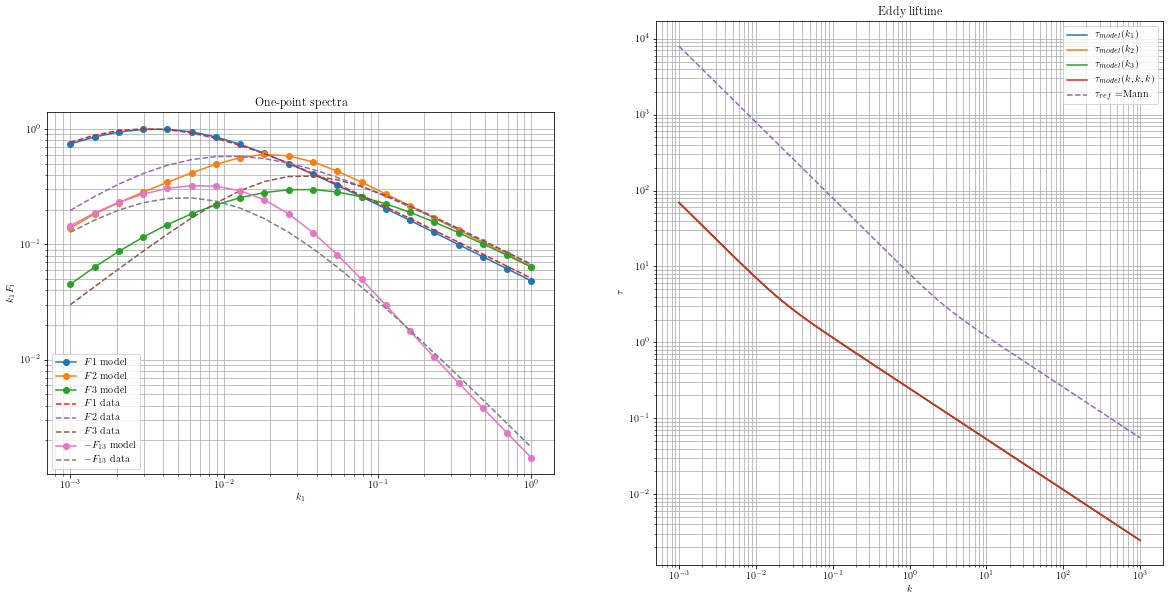

In [10]:
####################################
### Calibrate
####################################
opt_params = pb.calibrate(Data=Data, **config)#, OptimizerClass=torch.optim.RMSprop)

In [ ]:
####################################
### Export
####################################
if 'opt_params' not in locals():
    opt_params = pb.parameters
filename = config['output_folder'] + config['type_EddyLifetime'] + '_' + config['data_type'] + '.pkl'
with open(filename, 'wb') as file:
    pickle.dump([config, opt_params, Data, pb.loss_history_total, pb.loss_history_epochs], file)